In [30]:
import numpy as np
import pandas as pd

from numpy.linalg import matrix_rank
from numpy.linalg import norm
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances_argmin
from sklearn.svm import LinearSVC
import time
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

# Problem 1
NOTE: I added 3 lines to the movie ratings, 2 by friends and then my own ratings

In [165]:
def nmf_phi(A,W,H):
    return 0.5 * norm(A-W@H,ord='fro')**2

def kmeans(A,k, iters=1e4):
    def create_W(W_flat):
        W = np.zeros((n,k))
        for i in range(len(W_flat)):
            W[i,W_flat[i]] = 1
        return W
    
    def label_points(A, H):
        # This method assigns each data point to the nearest cluster by
        # computing the L2 distance between each A[i] and H[j].
        
        # Originally I did it in numpy (commented out below), but then realized that
        # the pairwise_distances_argmin function does the same computation but must faster.
        
        
        #return np.array([np.argmin(norm(a-H,axis=1)) for a in A])
        return pairwise_distances_argmin(A,H)
    
    iters = int(iters)
    n,d = A.shape
    
    H = A[np.random.permutation(n)[:k]]
    W_flat = label_points(A, H)
    
    losses = np.zeros(iters+1)
    losses[0] = nmf_phi(A,create_W(W_flat),H)
    
    for i in range(1, iters+1):
        H = np.array([A[W_flat==j].mean(axis=0) for j in range(k)])
        W_flat = label_points(A,H)
        losses[i] = nmf_phi(A,create_W(W_flat),H)
    return create_W(W_flat), H, losses
        

def nmf_pgd(A,k, W=None,H=None,iters = 1e4, alpha = 1e-3):
    iters = int(iters)
    n,d = A.shape
    if W is None:
        W = np.random.uniform(size=(n,k))
    if H is None:
        H = np.random.uniform(low=1,high=5,size=(k,d))
    
    losses = np.zeros(iters + 1)
    losses[0] = nmf_phi(A,W,H)
    
    for i in range(1,iters+1):
        R = A - W @ H
        W,H = np.maximum(W + alpha * R @ H.T,0), np.maximum(H + alpha * W.T@R,0)
        losses[i] = nmf_phi(A,W,H)
        
    return W, H, losses

def nmf_ls(A, k, W=None, H=None, iters = 1e4):
    iters = int(iters)
    n,d = A.shape
    if W is None:
        W = np.random.uniform(size=(n,k))
    if H is None:
        H = np.random.uniform(low=1,high=5,size=(k,d))
    
    losses = np.zeros(iters + 1)
    losses[0] = nmf_phi(A,W,H)
    
    # UPDATE SCHEME
    for i in range(1,iters+1):
        W,H = W*(A@H.T)/(W@H@H.T), H*(W.T@A)/(W.T@W@H)
        #W = W*(A@H.T)/(W@H@H.T)
        #H = H*(W.T@A)/(W.T@W@H)
        losses[i] = nmf_phi(A,W,H)
        
    return W, H, losses

def nmf_pgd_ls(A,k,W=None,H=None,iters=1e4,split=0.9,pgd_alpha=1e-3):
    iters = int(iters)
    n,d = A.shape
    if W is None:
        W = np.random.uniform(size=(n,k))
    if H is None:
        H = np.random.uniform(low=1,high=5,size=(k,d))
    
    iters_pgd = int(iters * split)
    iters_ls = iters - iters_pgd
    
    W, H, losses_pgd = nmf_pgd(A,k, W=W,H=H,iters = iters_pgd, alpha = pgd_alpha)
    W, H, losses_ls = nmf_ls(A, k, W=W, H=H, iters = iters_ls)
    return W, H, np.concatenate((losses_pgd,losses_ls[1:]))

In [3]:
A = pd.read_csv('dataset1/MovieRankings36.csv', delimiter=',', header=None)
A_submatrix = A.drop(A.columns[[0,2,7,9,12,13,14,15,16,18,19]], axis=1)
A_submatrix = A_submatrix[~np.isnan(A_submatrix).any(axis=1)].to_numpy()

In [4]:
k = 5
_,_,losses_km = kmeans(A_submatrix,k)
_,_,losses_pgd = nmf_pgd(A_submatrix,k,alpha=1e-4)
_,_,losses_ls = nmf_ls(A_submatrix,k)
_,_,losses_pgd_ls = nmf_pgd_ls(A_submatrix,k,pgd_alpha=1e-4)

# Problem 2

In [2]:
A = pd.read_csv('dataset1/MovieRankings36.csv', delimiter=',', header=None)
omega = 1.0 * A.notna().to_numpy()
A_complete = A.fillna(0).to_numpy()

In [64]:
CONVERGENCE_TOL = 1e-10

def dist(A, omega, M):
    return norm(omega*(A-M),ord='fro')

def mc_lrf_phi(A, omega, X, Y, l):
    return 0.5 * norm(omega*(A-X@Y.T),ord='fro')**2 + l/2*(norm(X,ord='fro')**2 + norm(Y,ord='fro')**2)

def mc_lrf(A,omega,k,l, X=None, Y=None, iters=1e4):
    iters = int(iters)
    n,d = A.shape
    
    def tikhonov_solver(X,b):
        _,d_ts = X.shape
        return np.linalg.solve(X.T@X + l * np.eye(d_ts),X.T@b)
    
    if X is None:
        X = np.random.normal(size=(n,k))
    if Y is None:
        Y = np.random.normal(size=(d,k))
    
    losses = np.zeros(iters+1)
    losses[0] = mc_lrf_phi(A, omega, X,Y, l)
    
    for epoch in range(1,iters+1):
        #iterate for X
        for i in range(n):
            omega_i = np.array(np.nonzero(omega[i])).flatten()
            X[i] = tikhonov_solver(Y[omega_i],A[i,omega_i])
        
        #iterate for Y
        for j in range(d):
            omega_j = np.array(np.nonzero(omega[:,j])).flatten()
            Y[j] = tikhonov_solver(X[omega_j],A[omega_j,j])
            
        losses[epoch] = mc_lrf_phi(A, omega, X, Y, l)
        if abs(losses[epoch] - losses[epoch-1]) < CONVERGENCE_TOL:
            losses = np.resize(losses,epoch+1)
            break
            
    return X,Y,losses

def mc_nnt_phi(A, omega, M, l):
    return 0.5 * norm(omega * (A-M), ord='fro')**2 + l * norm(M,ord='nuc')

def mc_nnt(A,omega,l, M=None, iters=1e4):
    def S_l(X):
        U, S, Vh = np.linalg.svd(X,full_matrices=False,compute_uv=True)
        return U @ np.diag(np.maximum(S-l,0)) @ Vh
    
    iters = int(iters)
    n,d = A.shape
    
    if M is None:
        M = np.random.uniform(low=1,high=5,size=(n,d))
    
    losses = np.zeros(iters+1)
    losses[0] = mc_nnt_phi(A, omega, M, l)
    
    for epoch in range(1, iters+1):
        M = S_l(M + omega * (A-M))
        losses[epoch] = mc_nnt_phi(A, omega, M, l)
        if abs(losses[epoch] - losses[epoch-1]) < CONVERGENCE_TOL:
            losses = np.resize(losses,epoch+1)
            break
    return M, losses

def run_test(A, omega, k, l, runs_per_each=10, lrf_or_nnt=True):
    print("Testing {} --> k={}, l={}".format(
        'lrf' if lrf_or_nnt else 'nnt',
        k,
        l))
    
    t = np.zeros(runs_per_each)
    epochs = np.zeros(runs_per_each)
    rank = np.zeros(runs_per_each)
    method_score = np.zeros(runs_per_each)
    frob_score = np.zeros(runs_per_each)
    
    M = X = Y = None
    
    for i in range(runs_per_each):
        t_first = time.time()
        if lrf_or_nnt:
            X, Y, losses = mc_lrf(A,omega,k,l)
            M = X@Y.T
        else:
            M, losses = mc_nnt(A,omega,l)
        t_second = time.time()
        
        t[i] = t_second - t_first
        epochs[i] = len(losses)
        rank = matrix_rank(M)
        method_score[i] = mc_lrf_phi(A, omega, X, Y, l) if lrf_or_nnt else mc_nnt_phi(A, omega, M, l)
        frob_score[i] = dist(A, omega, M)
    return t, epochs, rank, method_score, frob_score

In [65]:
mc_data_means = pd.DataFrame(columns=['method', 'l','k','time','epochs','rank','method_score','frob_score'])
mc_data_stds = pd.DataFrame(columns=['method', 'l','k','time','epochs','rank','method_score','frob_score'])
mc_data_mins = pd.DataFrame(columns=['method', 'l','k','time','epochs','rank','method_score','frob_score'])
mc_data_maxs = pd.DataFrame(columns=['method', 'l','k','time','epochs','rank','method_score','frob_score'])
ls = np.arange(0.5,6.1,0.5)
ks = np.arange(2,21,2)
for l in ls:
    t, epochs, rank, method_score, frob_score = run_test(A_complete, omega, -1, l, lrf_or_nnt=False)
    mc_data_means = mc_data_means.append({
        'method':'nnt',
        'l':l,
        'k':-1,
        'time':t.mean(),
        'epochs':epochs.mean(),
        'rank':rank.mean(),
        'method_score':method_score.mean(),
        'frob_score':frob_score.mean()},ignore_index=True)
    mc_data_stds = mc_data_stds.append({
        'method':'nnt',
        'l':l,
        'k':-1,
        'time':t.std(),
        'epochs':epochs.std(),
        'rank':rank.std(),
        'method_score':method_score.std(),
        'frob_score':frob_score.std()},ignore_index=True)
    mc_data_mins = mc_data_mins.append({
        'method':'nnt',
        'l':l,
        'k':-1,
        'time':t.min(),
        'epochs':epochs.min(),
        'rank':rank.min(),
        'method_score':method_score.min(),
        'frob_score':frob_score.min()},ignore_index=True)
    mc_data_maxs = mc_data_maxs.append({
        'method':'nnt',
        'l':l,
        'k':-1,
        'time':t.max(),
        'epochs':epochs.max(),
        'rank':rank.max(),
        'method_score':method_score.max(),
        'frob_score':frob_score.max()},ignore_index=True)
    
    for k in ks:
        t_first = time.time()
        X_lrf, Y_lrf, losses_lrf = mc_lrf(A_complete,omega,k,l)
        t_second = time.time()
        M_lrf = X_lrf @ Y_lrf.T
        
        t, epochs, rank, method_score, frob_score = run_test(A_complete, omega, k, l, lrf_or_nnt=True)

        mc_data_means = mc_data_means.append({
            'method':'lrf',
            'l':l,
            'k':k,
            'time':t.mean(),
            'epochs':epochs.mean(),
            'rank':rank.mean(),
            'method_score':method_score.mean(),
            'frob_score':frob_score.mean()},ignore_index=True)
        mc_data_stds = mc_data_stds.append({
            'method':'lrf',
            'l':l,
            'k':k,
            'time':t.std(),
            'epochs':epochs.std(),
            'rank':rank.std(),
            'method_score':method_score.std(),
            'frob_score':frob_score},ignore_index=True)
        mc_data_mins = mc_data_mins.append({
            'method':'lrf',
            'l':l,
            'k':k,
            'time':t.min(),
            'epochs':epochs.min(),
            'rank':rank.min(),
            'method_score':method_score.min(),
            'frob_score':frob_score.min()},ignore_index=True)
        mc_data_maxs = mc_data_maxs.append({
            'method':'lrf',
            'l':l,
            'k':k,
            'time':t.max(),
            'epochs':epochs.max(),
            'rank':rank.max(),
            'method_score':method_score.max(),
            'frob_score':frob_score.max()},ignore_index=True)
        

Testing nnt --> k=-1, l=0.5
Testing lrf --> k=2, l=0.5
Testing lrf --> k=4, l=0.5
Testing lrf --> k=6, l=0.5
Testing lrf --> k=8, l=0.5
Testing lrf --> k=10, l=0.5
Testing lrf --> k=12, l=0.5
Testing lrf --> k=14, l=0.5
Testing lrf --> k=16, l=0.5
Testing lrf --> k=18, l=0.5
Testing lrf --> k=20, l=0.5
Testing nnt --> k=-1, l=1.0
Testing lrf --> k=2, l=1.0
Testing lrf --> k=4, l=1.0
Testing lrf --> k=6, l=1.0
Testing lrf --> k=8, l=1.0
Testing lrf --> k=10, l=1.0
Testing lrf --> k=12, l=1.0
Testing lrf --> k=14, l=1.0
Testing lrf --> k=16, l=1.0
Testing lrf --> k=18, l=1.0
Testing lrf --> k=20, l=1.0
Testing nnt --> k=-1, l=1.5
Testing lrf --> k=2, l=1.5
Testing lrf --> k=4, l=1.5
Testing lrf --> k=6, l=1.5
Testing lrf --> k=8, l=1.5
Testing lrf --> k=10, l=1.5
Testing lrf --> k=12, l=1.5
Testing lrf --> k=14, l=1.5
Testing lrf --> k=16, l=1.5
Testing lrf --> k=18, l=1.5
Testing lrf --> k=20, l=1.5
Testing nnt --> k=-1, l=2.0
Testing lrf --> k=2, l=2.0
Testing lrf --> k=4, l=2.0
Testin

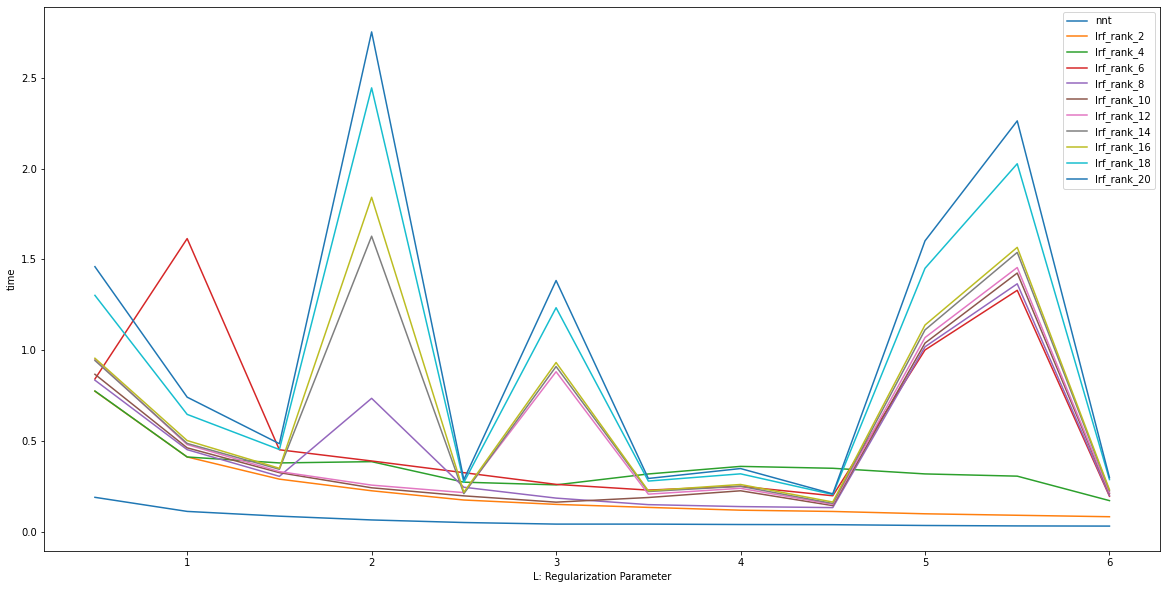

In [77]:
l_or_k = True
plot_y = 'time'
x = None
ys = []

df = mc_data_means

if l_or_k:
    x = ls
    ys.append((df[mc_data_stds['method']=='nnt'][plot_y],'nnt'))
    for k in ks:
        ys.append((df[(df['method']=='lrf') & (df['k']==k)][plot_y],'lrf_rank_{}'.format(k)))
else:
    x = ks
    for l in ls:
        ys.append((df[(df['method']=='lrf') & (df['l']==l)][plot_y],'lrf_lambda_{}'.format(l)))
        
plt.figure(figsize=(20,10))
for y in ys:
    plt.plot(x,y[0],label=y[1])
    
plt.xlabel("L: Regularization Parameter" if l_or_k else "K: Rank of Factorization")
plt.ylabel(plot_y)
plt.legend()
plt.show()

In [ ]:
k = 13
l = 0.05
X_lrf,Y_lrf, losses_lrf = mc_lrf(A_complete, omega, k, l)
M_lrf = X_lrf @ Y_lrf.T
M_nnt, losses_nnt = mc_nnt(A_complete, omega, l)

plt.figure(figsize=(20,10))
plt.plot(losses_lrf)
plt.plot(losses_nnt)
plt.show()

# Problem 3

In [8]:
def CUR(A, c, r, k):
    def column_select(A,c):
        n,d = A.shape
        _, _, Vh = np.linalg.svd(A,full_matrices=False,compute_uv=True)
        V_k = Vh[:k].T
        pi = np.array([norm(v_i)**2/k for v_i in V_k])
        
        columns = []
        for j in range(d):
            if np.random.uniform() <= min(1,c*pi[j]):
                columns.append(j)
        return A[:,columns]
    
    C = column_select(A,c)
    R = column_select(A.T,r)
    U = np.linalg.lstsq(R,np.linalg.lstsq(C,A,rcond=None)[0].T,rcond=None)[0].T
    return C, U, R

In [9]:
M = pd.read_csv('dataset2/M.csv', delimiter=',', header=None).to_numpy()

In [10]:
k_list = np.arange(2,11)
a_list = np.arange(1,9)
runs = 100

ratio = np.zeros((len(k_list),len(a_list)))
trunc_svd_norm = np.zeros(len(k_list))

U_M, S_M, Vh_M = np.linalg.svd(M,full_matrices=False,compute_uv=True)

for i_k in range(len(k_list)):
    k = k_list[i_k]
    print("Working on k={}".format(k))

    M_k = U_M[:,:k] @ np.diag(S_M[:k]) @ Vh_M[:k,:]
    trunc_svd_norm[i_k] = norm(M-M_k, ord='fro')
    
    for i_a in range(len(a_list)):
        a = a_list[i_a]
        print("\tWorking on a={}".format(a))
        
        for i_run in range(runs):
            C, U, R = CUR(M, a*k, a*k, k)
            ratio[i_k,i_a] += norm(M-C@U@R.T, ord='fro') / trunc_svd_norm[i_k]
        ratio[i_k,i_a] /= runs

Working on k=2
	Working on a=1
	Working on a=2
	Working on a=3
	Working on a=4
	Working on a=5
	Working on a=6
	Working on a=7
	Working on a=8
Working on k=3
	Working on a=1
	Working on a=2
	Working on a=3
	Working on a=4
	Working on a=5
	Working on a=6
	Working on a=7
	Working on a=8
Working on k=4
	Working on a=1
	Working on a=2
	Working on a=3
	Working on a=4
	Working on a=5
	Working on a=6
	Working on a=7
	Working on a=8
Working on k=5
	Working on a=1
	Working on a=2
	Working on a=3
	Working on a=4
	Working on a=5
	Working on a=6
	Working on a=7
	Working on a=8
Working on k=6
	Working on a=1
	Working on a=2
	Working on a=3
	Working on a=4
	Working on a=5
	Working on a=6
	Working on a=7
	Working on a=8
Working on k=7
	Working on a=1
	Working on a=2
	Working on a=3
	Working on a=4
	Working on a=5
	Working on a=6
	Working on a=7
	Working on a=8
Working on k=8
	Working on a=1
	Working on a=2
	Working on a=3
	Working on a=4
	Working on a=5
	Working on a=6
	Working on a=7
	Working on a=8

# Problem 4

In [39]:
M = pd.read_csv('dataset2/M.csv', delimiter=',', header=None).to_numpy()
y = pd.read_csv('dataset2/y.csv', delimiter=',', header=None).to_numpy().flatten()

with open('dataset2/features_idx.txt') as feature_text:
    text_assignments = feature_text.readlines()[9:]
    words = [k.split()[1] for k in text_assignments]

In [40]:
def get_max_k_scores(scores, k):
    return scores.argsort()[-k:][::-1]

@ignore_warnings(category=ConvergenceWarning)
def score_separability(Z,y):
    return LinearSVC(C=1,max_iter=20000).fit(Z,y).score(Z,y)

def plot_separability_by_k(scoring_function_name, k_vals, separability):
    plt.figure(figsize=(20,8))
    plt.title("{}: Separability for k in [{},{}]".format(scoring_function_name.upper(),k_vals.min(),k_vals.max()))
    plt.plot(k_vals,separability)
    plt.axis([k_vals.min(),k_vals.max(),0,1])
    plt.xlabel("Number of columns selected")
    plt.ylabel("LinearSVM Accuracy")
    plt.show()

def plot_best(m,k,s,Z,y):
    plt.figure(figsize=(20,8))
    plt.title("{}: Best K = {}, Best Separability = {}".format(m.upper(),k,s))
    plt.scatter(Z[y==1][:,0],Z[y==1][:,1],c='red')
    plt.scatter(Z[y!=1][:,0],Z[y!=1][:,1],c='blue')
    plt.xlabel("PCA: v2")
    plt.ylabel("PCA: v1")
    plt.show()

def PCA(M,y,top_5=False):
    X = M.copy()
    if top_5:
        X = X[:,get_max_k_scores(leverage_scores(X,None), 5)]
    X = X - X.mean(axis=0)
    _, S, Vh = np.linalg.svd(X,full_matrices=False,compute_uv=True)
    Z = X @ Vh.T[:,0:2]
    return Z

In [41]:
# Difference in percentage appearances stratified by y
def stratify_percent_scores(M,y):
    indicator = M>0
    counts_pos = indicator[y==1].mean(axis=0)
    counts_neg = indicator[y==-1].mean(axis=0)
    return np.abs(counts_pos-counts_neg)

# Difference in leverage score stratified by y
def stratify_leverage_scores(M,y):
    pos = M[y==1]
    neg = M[y==-1]
    pos_lev_scores = leverage_scores(pos,None)
    neg_lev_scores = leverage_scores(neg,None)
    return np.abs(pos_lev_scores-neg_lev_scores)

# Count of number of unique appearances
def indicator_scores(M,_):
    return (M > 0).sum(axis=0)

# Random score (baseline)
def random_scores(M,_):
    n,d = M.shape
    return np.random.normal(size=d)

# Leverage score, using entire SVD
def leverage_scores(M,_):
    _, _, Vh = np.linalg.svd(M,full_matrices=False,compute_uv=True)
    return np.array([norm(v_i)**2 for v_i in Vh.T])

# Leverage score, only using k-th SVD
def leverage_k_scores(k):
    def leverage_k_scores_helper(M,k,_):
        _, _, Vh = np.linalg.svd(M,full_matrices=False,compute_uv=True)
        V_k = Vh[:k].T
        return np.array([norm(v_i)**2 for v_i in V_k])
    return lambda M,y: leverage_k_scores_helper(M,k,None)

# avg percent of document makeup
def avg_percent_scores(M,_):
    sums = M.sum(axis=1)
    by_doc_percent = M/sums[:,None]
    return by_doc_percent.mean(axis=0)

# total count of words
def total_count_scores(M,_):
    return M.sum(axis=0)

scoring_functions = {
    'stratify_percent_scores' : stratify_percent_scores,
    'stratify_leverage_scores' : stratify_leverage_scores,
    'indicator_scores' : indicator_scores,
    'random_scores' : random_scores,
    'leverage_scores' : leverage_scores,
    'avg_percent_scores' : avg_percent_scores,
    'total_count_scores' : total_count_scores,
}

for k in range(5,12):
    scoring_functions['leverage_scores_{}'.format(k)] = leverage_k_scores(k)

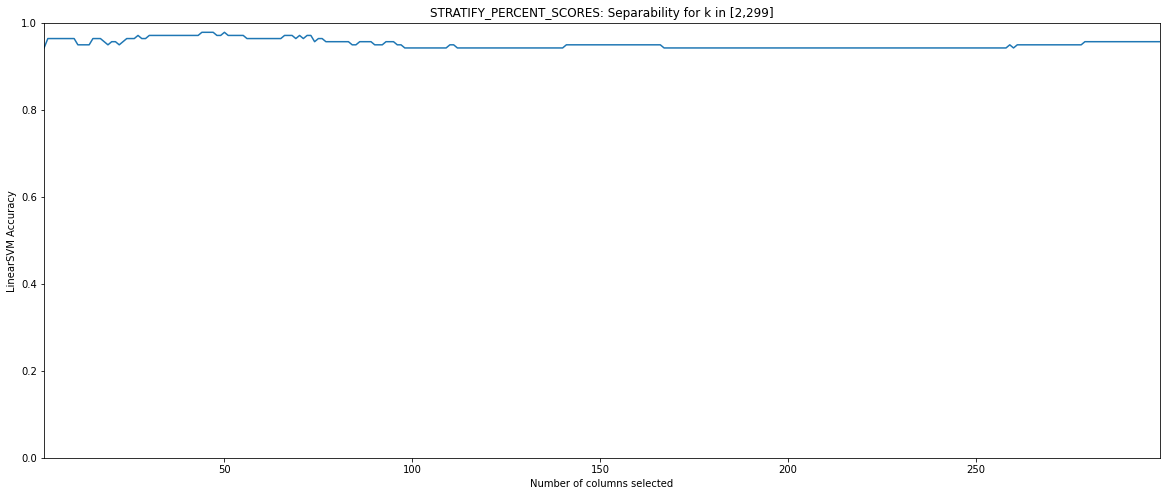

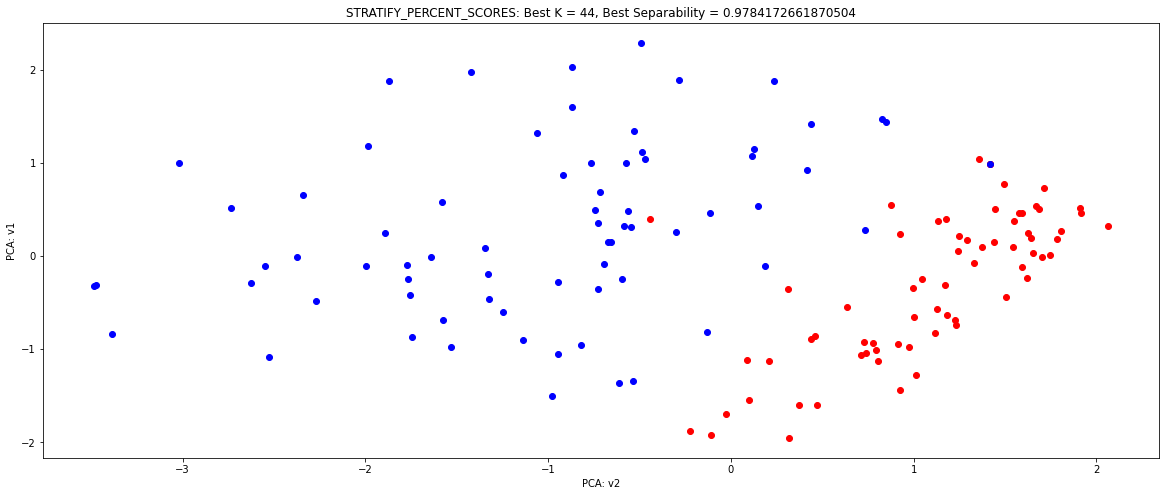

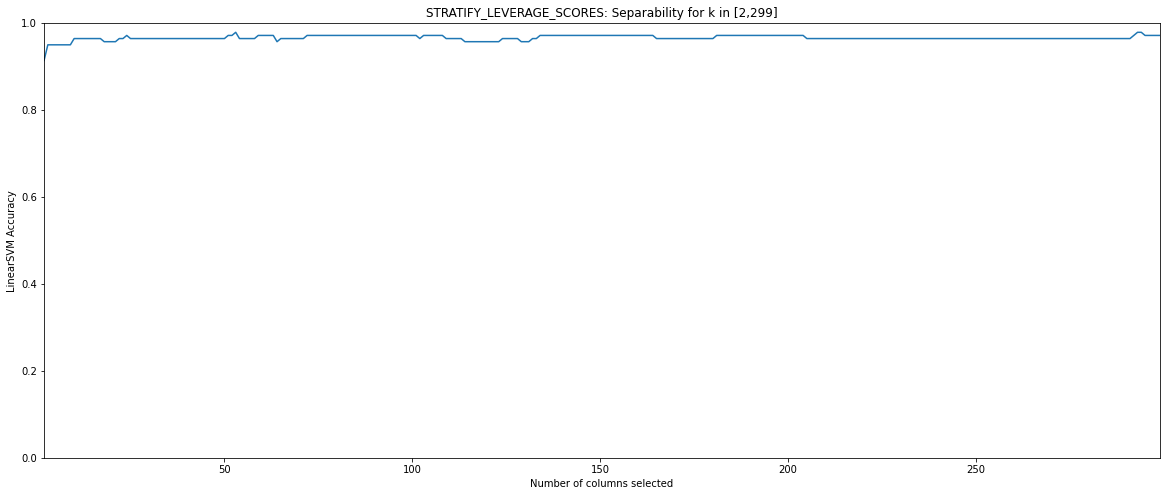

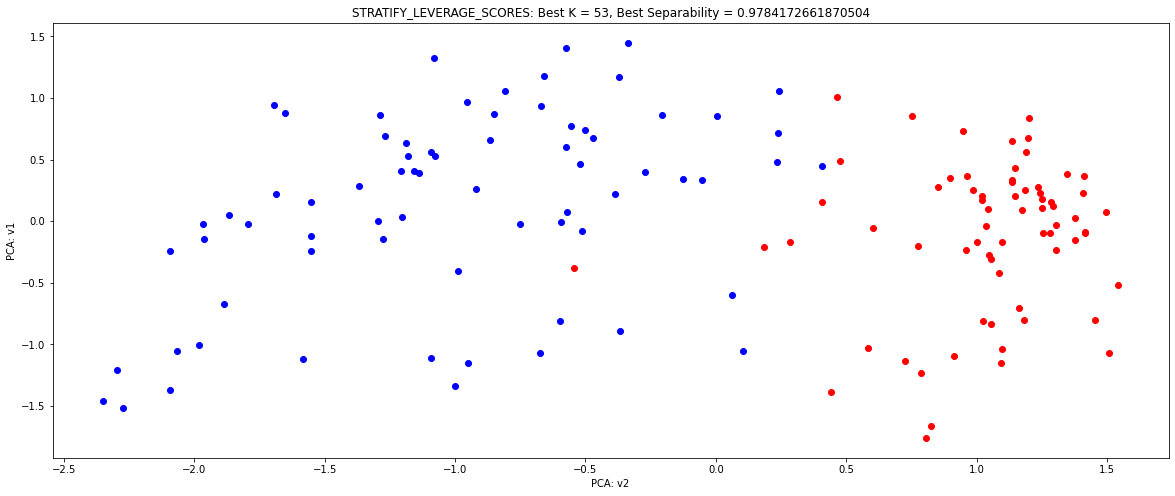

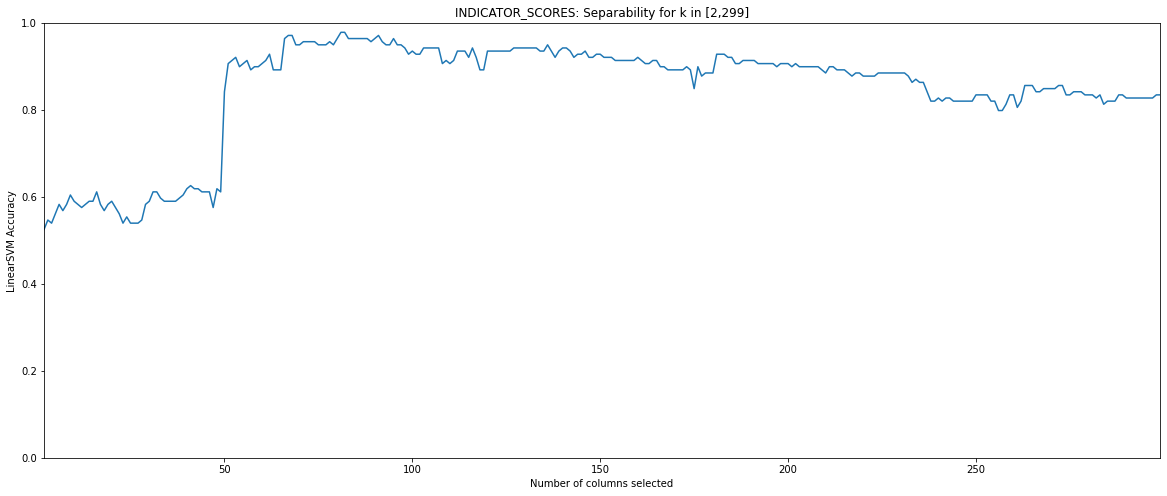

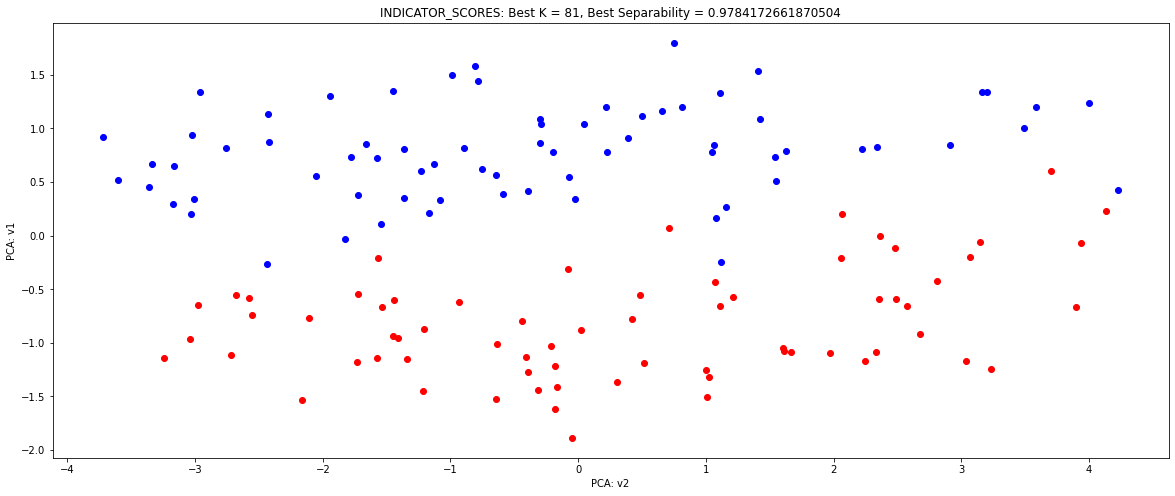

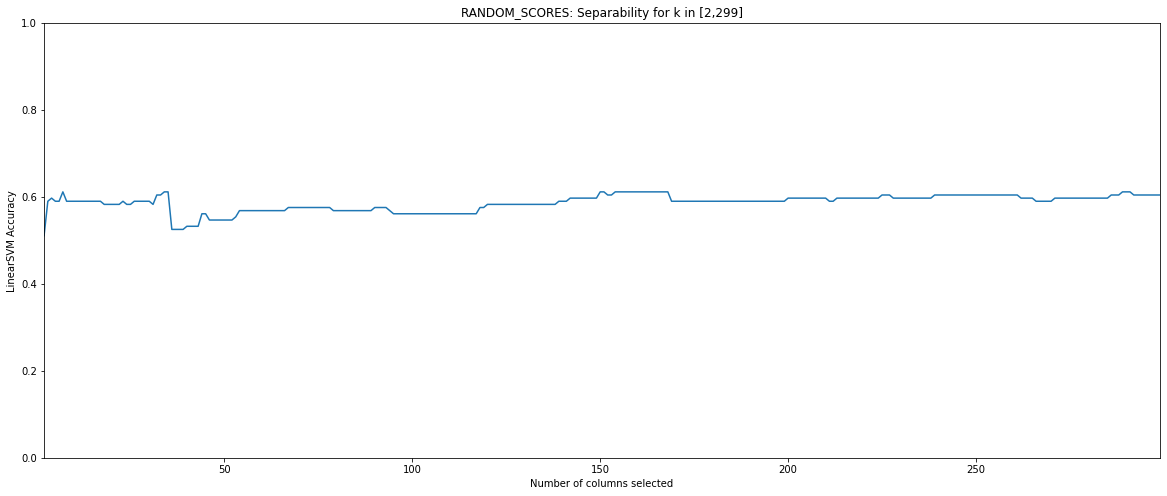

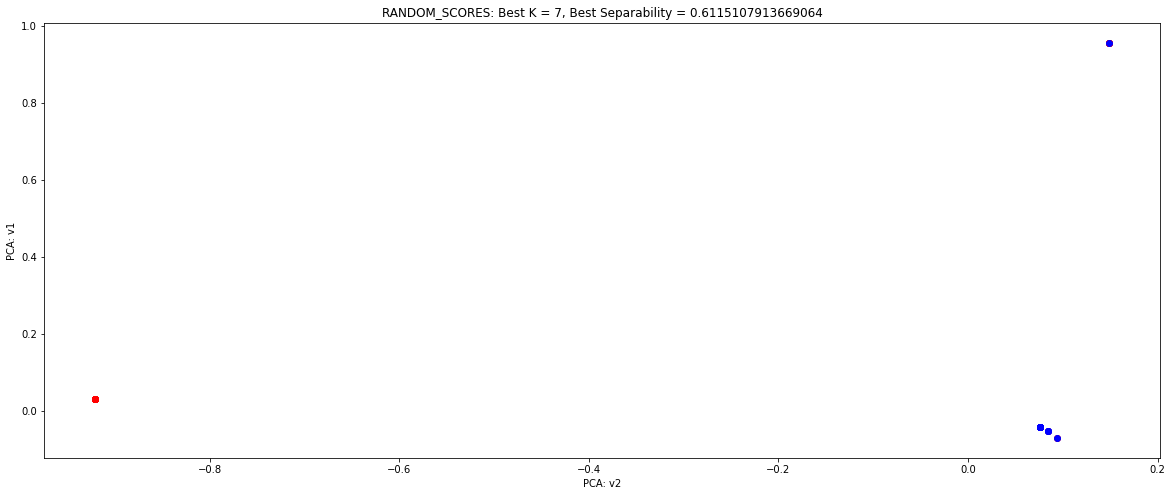

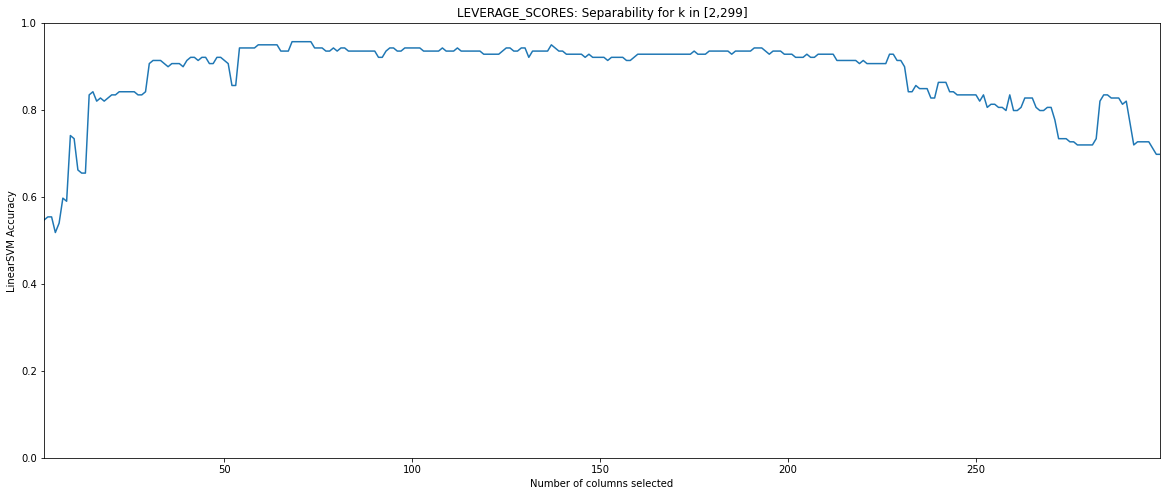

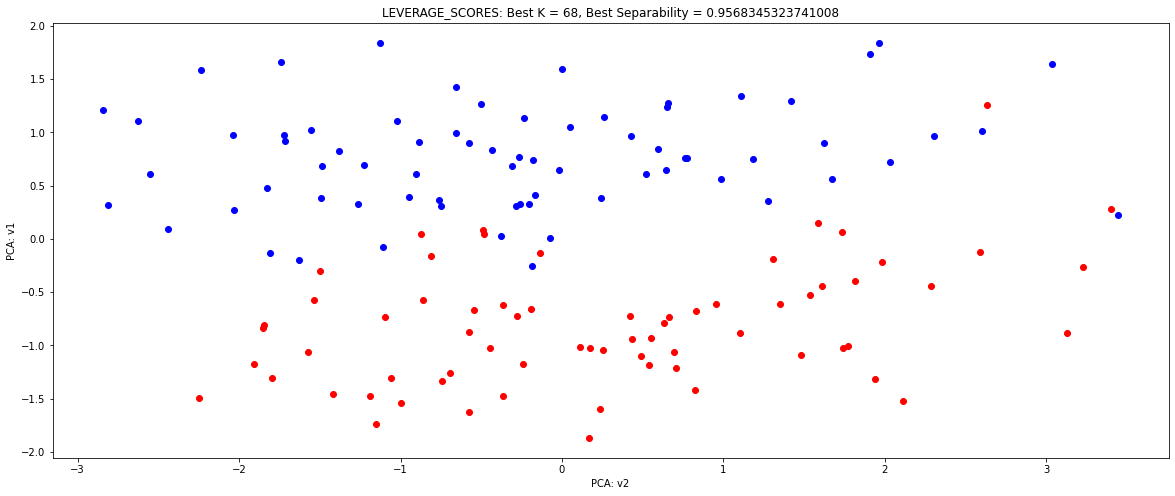

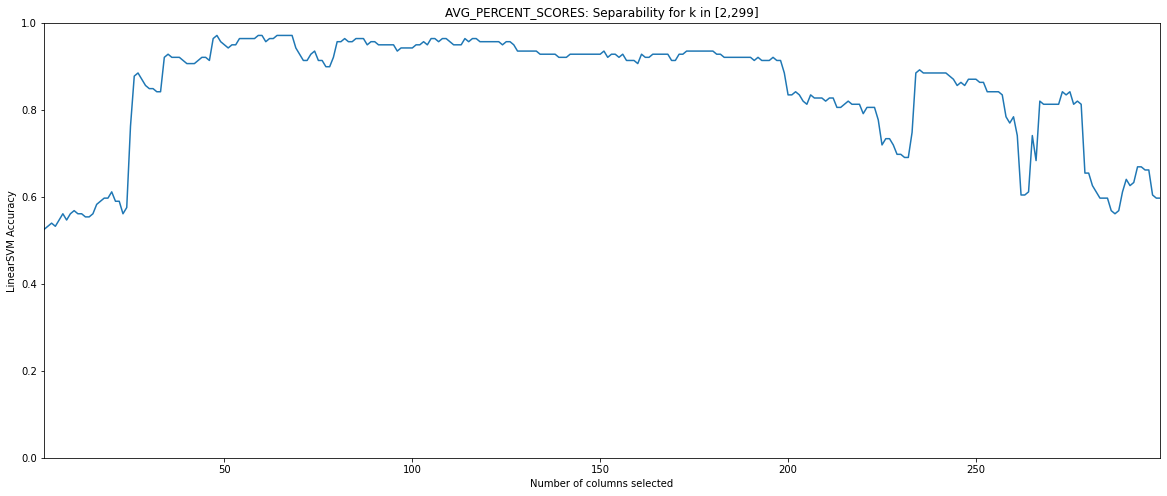

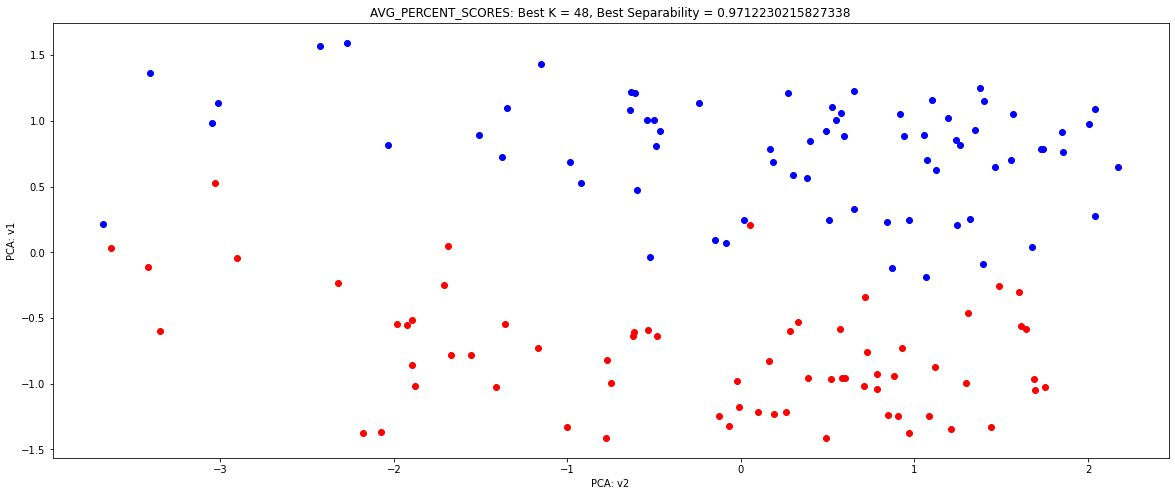

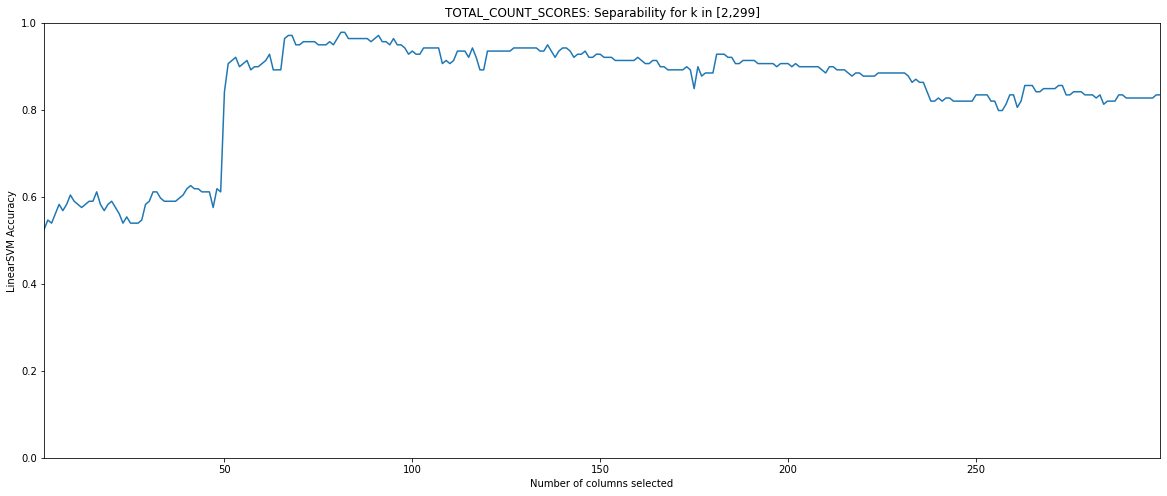

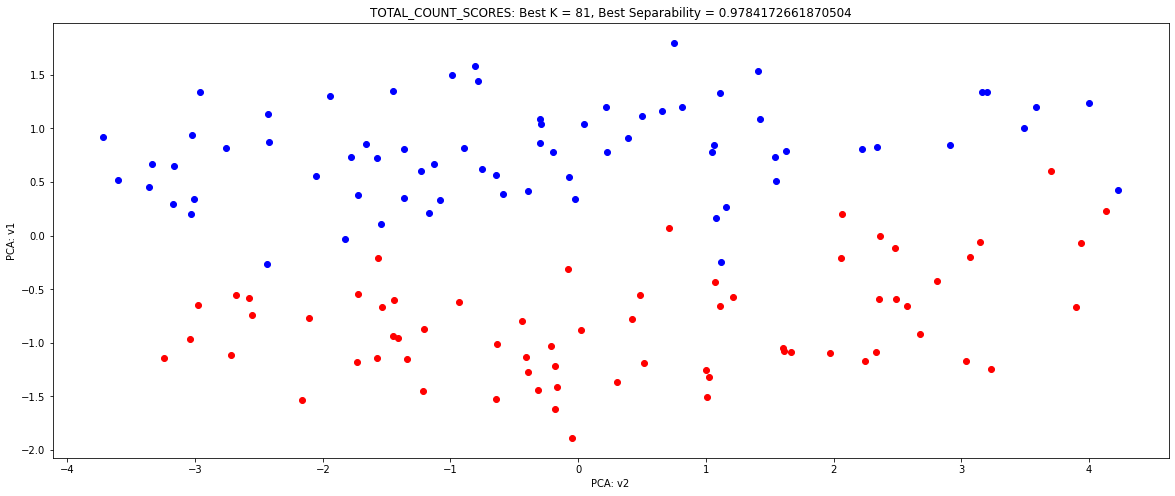

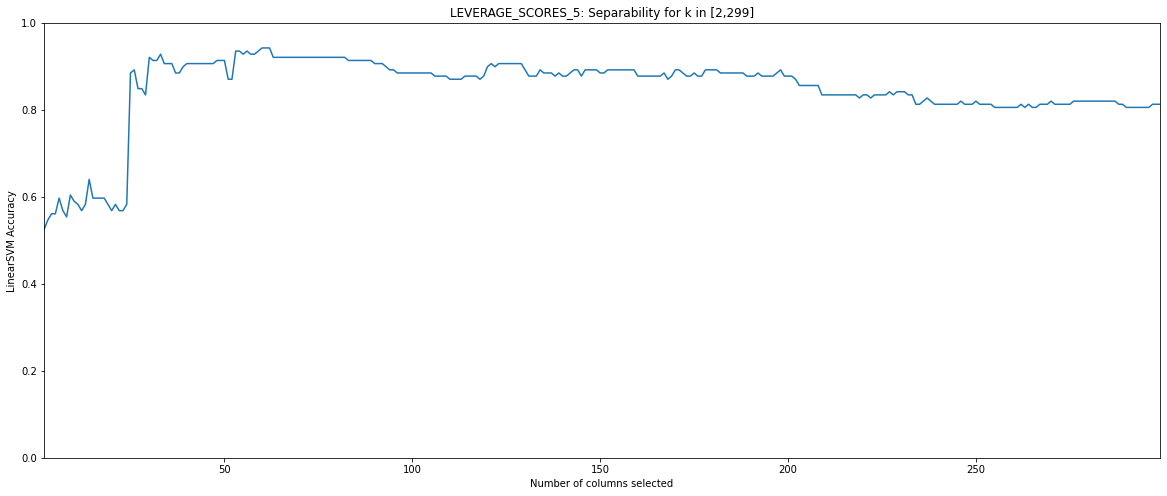

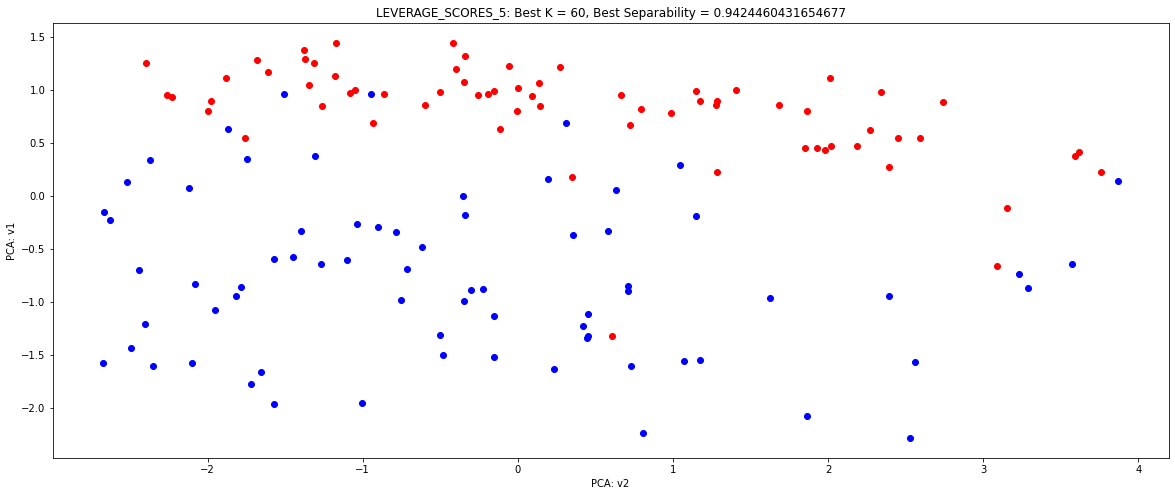

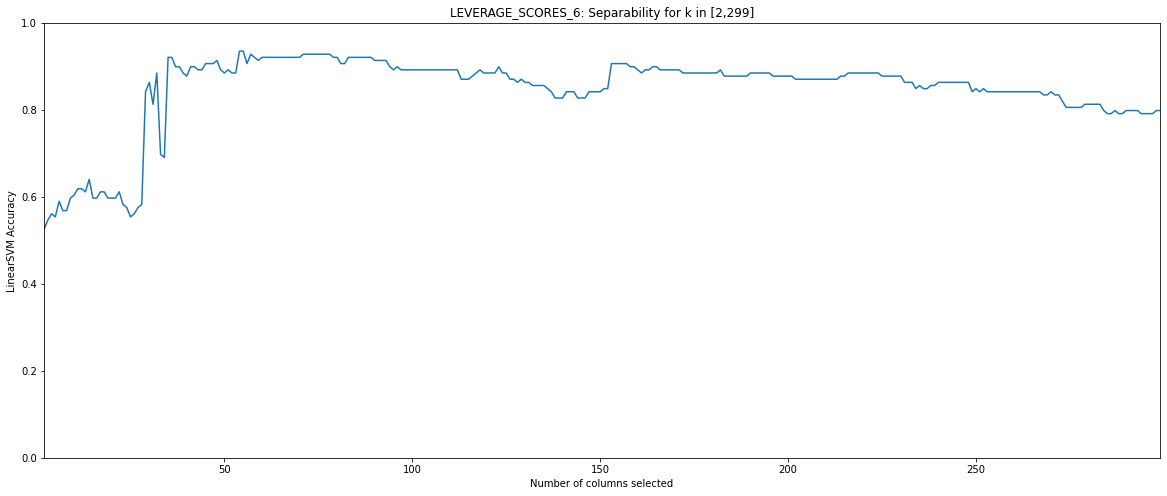

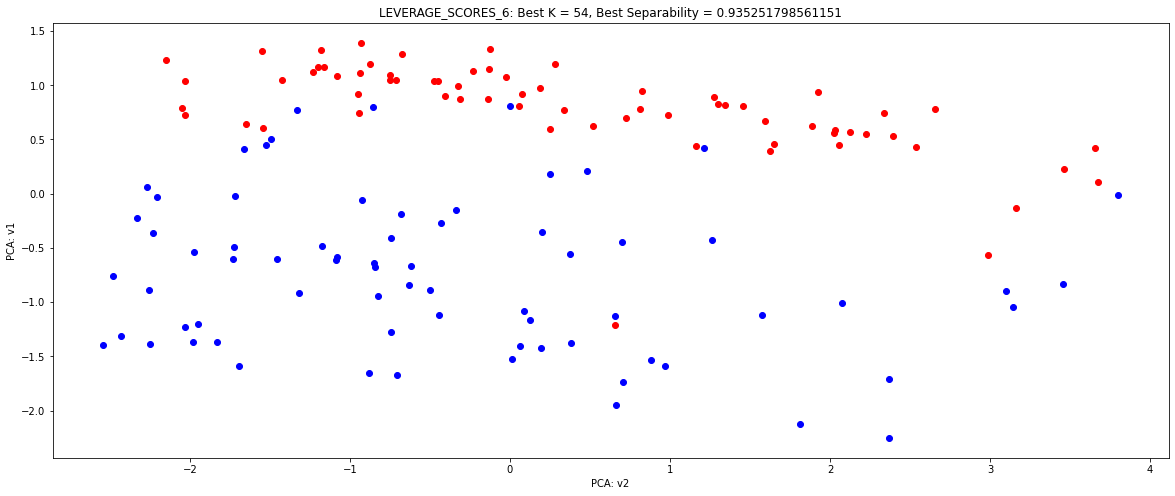

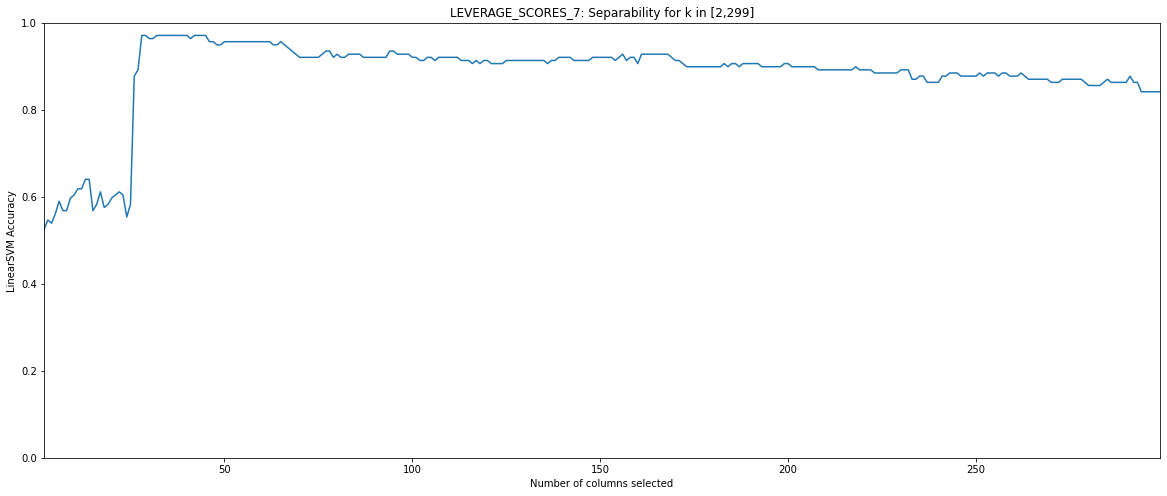

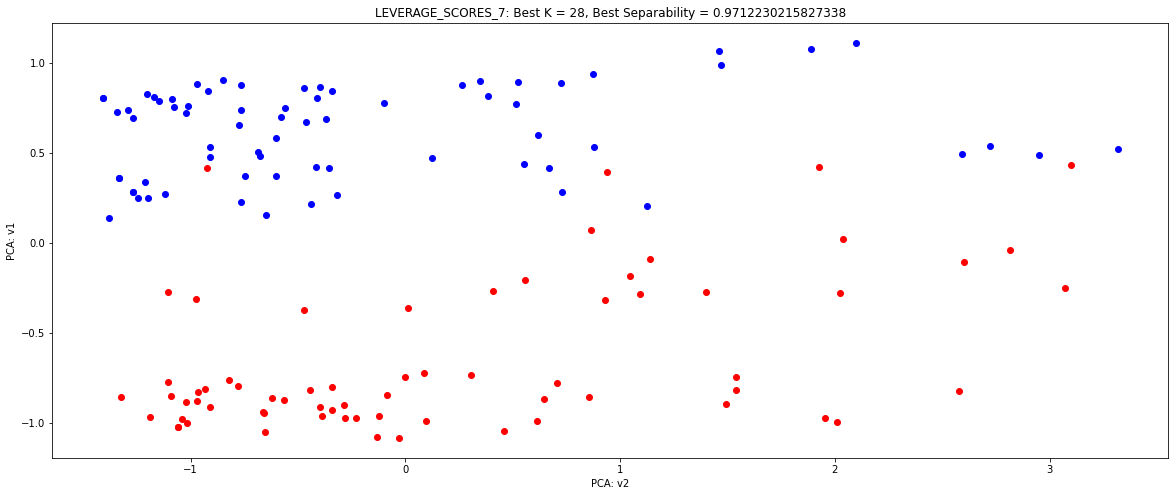

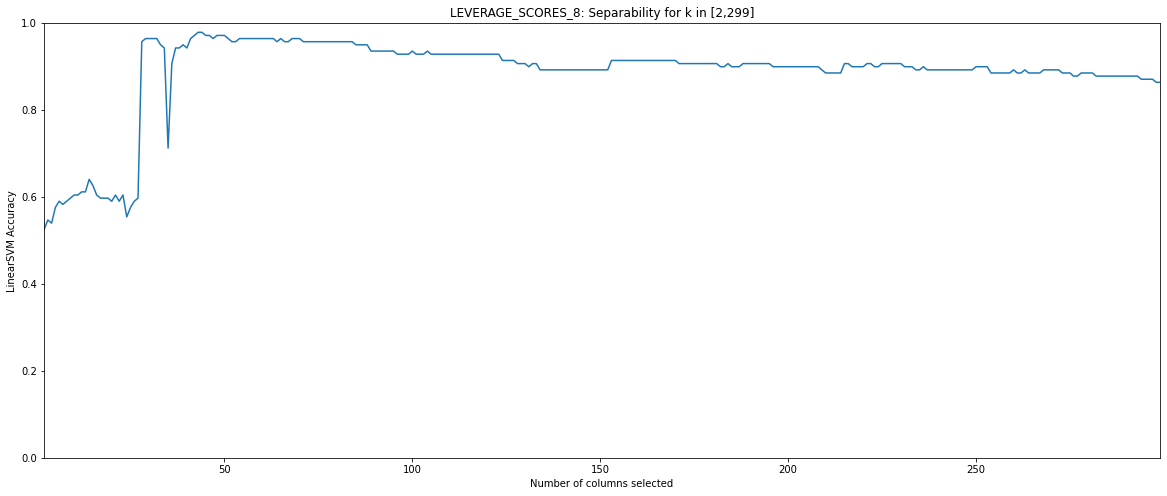

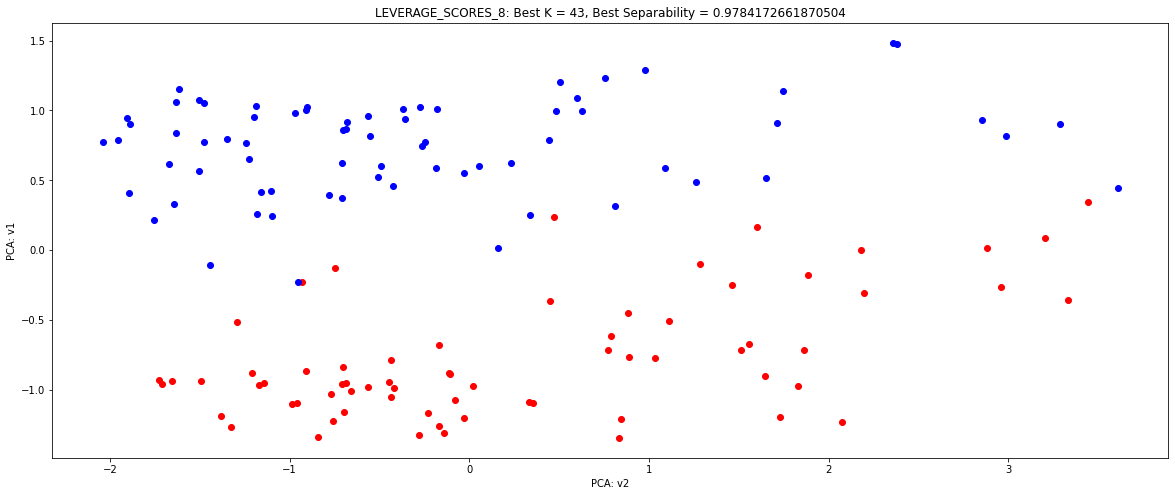

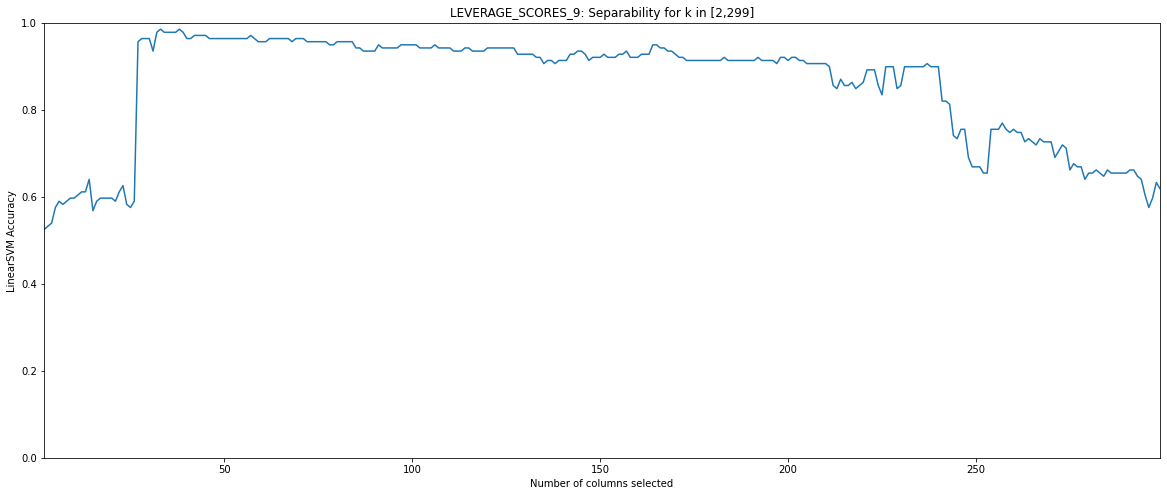

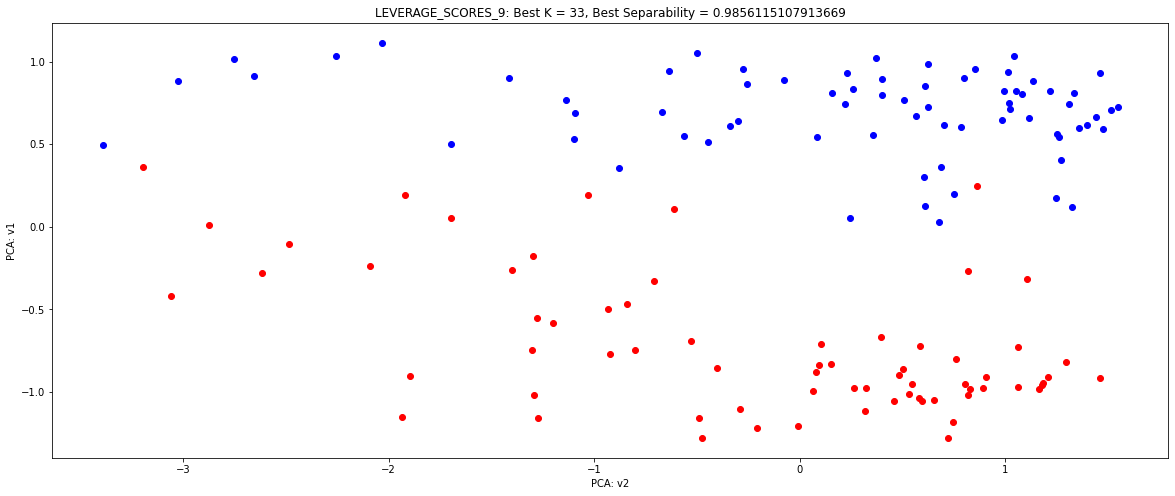

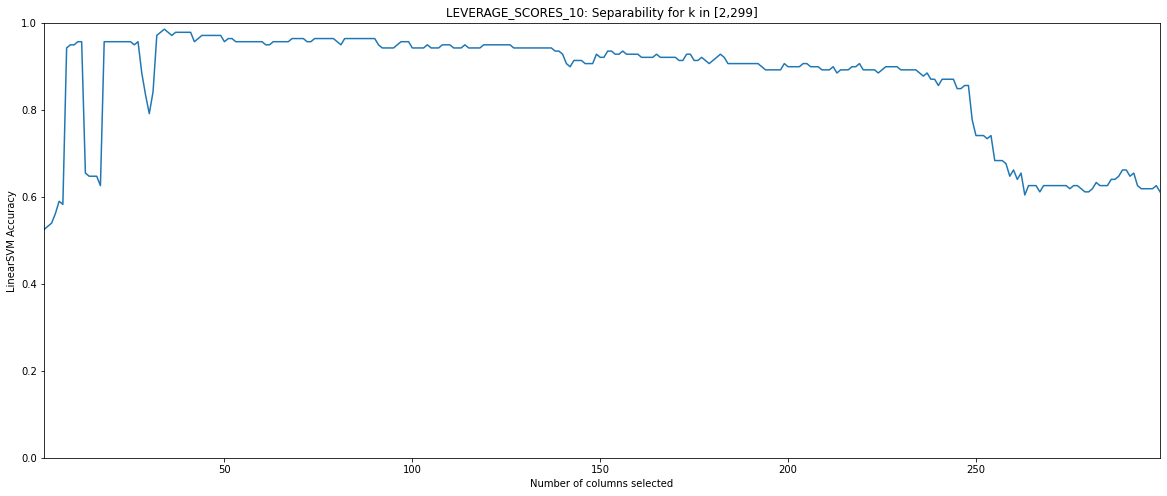

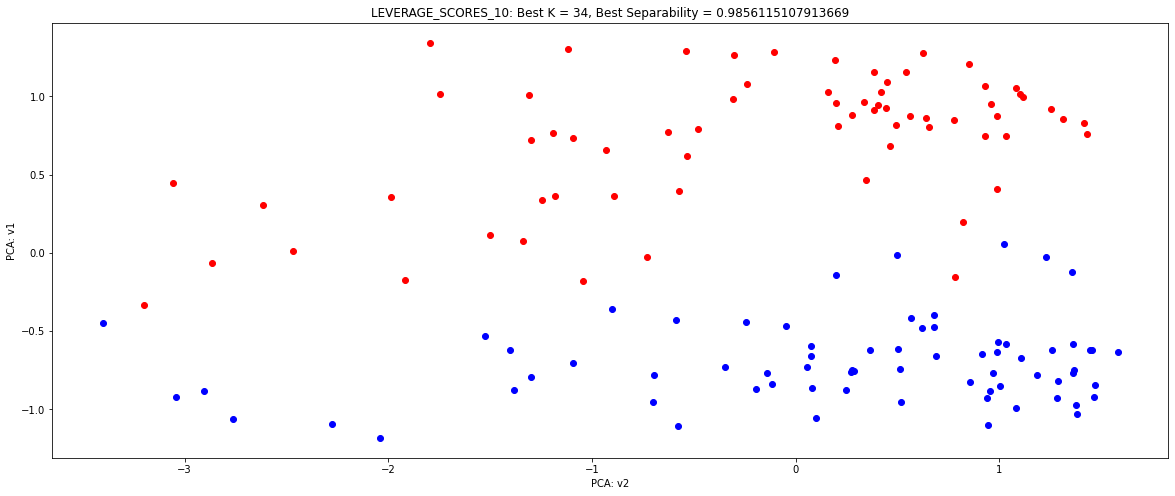

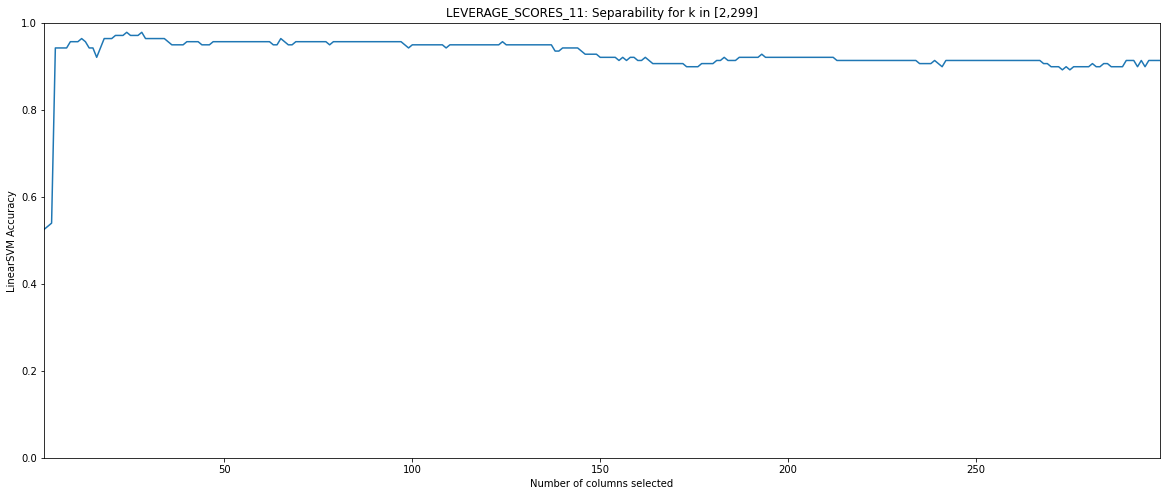

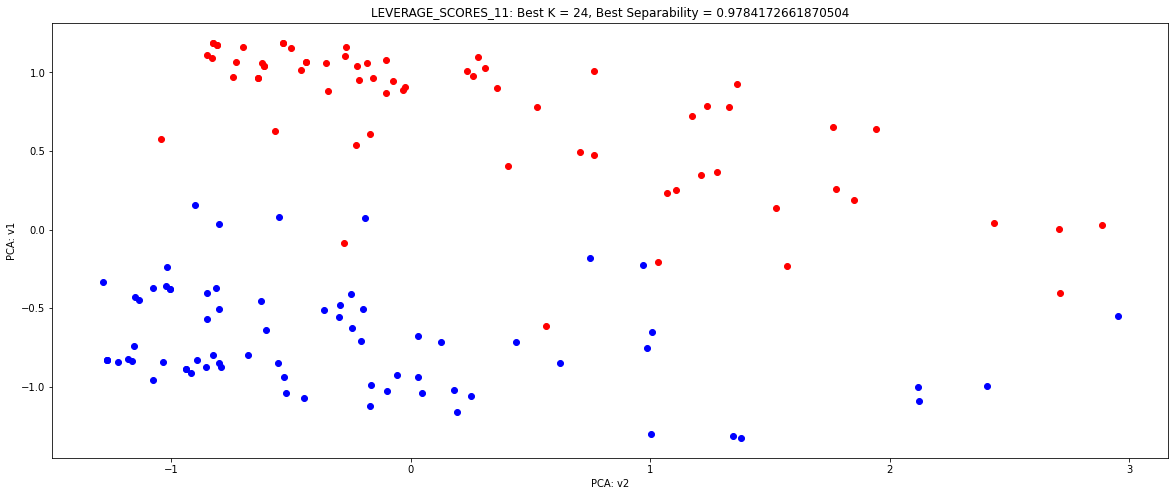

In [42]:
k_vals = np.arange(2,300)
separability = {}
best_words = {}
best_separability = {}
top_5 = False

for scoring_function_name in scoring_functions:
    scoring_function = scoring_functions[scoring_function_name]
    scores = scoring_function(M,y)
    separability[scoring_function_name] = np.zeros(len(k_vals))
    
    for i in range(len(k_vals)):
        k = k_vals[i]
        selected_columns = get_max_k_scores(scores, k)
        M_subset = M[:,selected_columns]
        Z = PCA(M_subset,y,top_5)
        separability[scoring_function_name][i] = score_separability(Z,y)
    
    plot_separability_by_k(scoring_function_name, k_vals, separability[scoring_function_name])
    
    i_best = separability[scoring_function_name].argmax()
    k_best = k_vals[i_best]
    best_separability[scoring_function_name] = separability[scoring_function_name][i_best]
    
    selected_columns_best = get_max_k_scores(scores, k_best)
    best_words[scoring_function_name] = set([words[selected_column] for selected_column in selected_columns_best])
    
    M_subset_best = M[:,selected_columns_best]
    Z_best = PCA(M_subset_best,y,top_5)

    plot_best(scoring_function_name, k_best, best_separability[scoring_function_name], Z_best,y)
#    print("Word list: {}\n\n".format(best_words[scoring_function_name]))

In [57]:
common_words = None
threshold = 0.95
word_count = {}
for scoring_function_name in scoring_functions:
    if best_separability[scoring_function_name] > threshold:
        for word in best_words[scoring_function_name]:
            if word not in word_count:
                word_count[word] = 0
            word_count[word] += 1
            
        if common_words is None:
            common_words = set(best_words[scoring_function_name])
        else:
            common_words &= set(best_words[scoring_function_name])
        

In [55]:
print(common_words)

{'indiana', 'evansville'}


In [76]:
for word in word_count:
    if word_count[word] == 10:
        print(word,word_count[word])

will 10
information 10
services 10
for 10
that 10
gif 10
our 10
your 10
home 10
the 10
all 10
you 10
and 10
from 10
